In [97]:
import pandas as pd
import numpy as np
from env import username, password, host
import wrangle
import prepare
from scipy import stats
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Acquire

In [3]:
url = f"mysql+pymysql://{username}:{password}@{host}/zillow"
# this query brings in all the columns necessary to ask the questions posed by the zillow team  
query = """
            
SELECT parcelid, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, taxamount, assessmentyear, regionidcounty,regionidzip, transactiondate
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)

JOIN predictions_2017 USING(parcelid)

WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")
                              AND (transactiondate BETWEEN '2017-05-01' AND '2017-08-31');
                              
                              """
    
df = pd.read_sql(query, url)
df

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,transactiondate
0,12354372,2.0,1.0,756.0,83520.0,1355.47,2016.0,3101.0,96119.0,2017-05-08
1,13973867,4.0,3.0,1850.0,517000.0,6116.96,2016.0,1286.0,97004.0,2017-05-08
2,13981618,3.0,2.5,3271.0,1814378.0,19686.04,2016.0,1286.0,96978.0,2017-05-08
3,17120696,4.0,2.5,1807.0,265679.0,3150.70,2016.0,2061.0,97107.0,2017-05-08
4,12438626,4.0,3.0,2468.0,443691.0,5364.53,2016.0,3101.0,96242.0,2017-05-08
...,...,...,...,...,...,...,...,...,...,...
28119,11927617,3.0,2.0,1345.0,634832.0,7395.36,2016.0,3101.0,96517.0,2017-08-30
28120,14210331,2.0,1.5,1087.0,319000.0,3570.20,2016.0,1286.0,97063.0,2017-08-30
28121,11446352,4.0,2.0,1271.0,514037.0,5996.69,2016.0,3101.0,96162.0,2017-08-30
28122,12954981,4.0,2.0,2058.0,532592.0,6151.04,2016.0,3101.0,96524.0,2017-08-30


In [4]:
### PREARE ###

In [5]:
# I need to prepare one df for answering the questions posed and a 2nd df name df2 that is for exploring and modeling

In [6]:
df.info()
# these are all the correct datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28124 non-null  int64  
 1   bedroomcnt                    28124 non-null  float64
 2   bathroomcnt                   28124 non-null  float64
 3   calculatedfinishedsquarefeet  28077 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   taxamount                     28123 non-null  float64
 6   assessmentyear                28124 non-null  float64
 7   regionidcounty                28124 non-null  float64
 8   regionidzip                   28107 non-null  float64
 9   transactiondate               28124 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.1+ MB


Feature                             Description

'assessmentyear':	                The year of the property tax assessment 
'bathroomcnt':   	                Number of bathrooms in home including fractional bathrooms
'bedroomcnt':   	                Number of bedrooms in home 
'calculatedfinishedsquarefeet': 	Calculated total finished living area of the home 
'parcelid':                     	Unique identifier for parcels (lots) 
'regionidcounty':                	County in which the property is located
'regionidzip':                  	Zip code in which the property is located
'taxamount':                        The total property tax assessed for that assessment year
'taxvaluedollarcnt':             	The total tax assessed value of the parcel

-I chose to use the column regionidzip instead of fips because this holds the actual zipcode
-I chose to keep parcelid so I could use it as the index 
-I chose to use calculatedfinishedsquarefeet because all of the other squarefeet features did not include the amount that would be advertised with the house which would only be the finished sqft
-I brought in the assessmentyear in order to only capture homes in the year of 2017
-Last I brought in transaction date to limit the dataset to only those homes with tranactions in the "hot months" May through August

In [7]:
# here I check out all the columns I brought in to make sure I have all
# of the information necessary to answer questions posed by the team
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,transactiondate
0,12354372,2.0,1.0,756.0,83520.0,1355.47,2016.0,3101.0,96119.0,2017-05-08
1,13973867,4.0,3.0,1850.0,517000.0,6116.96,2016.0,1286.0,97004.0,2017-05-08
2,13981618,3.0,2.5,3271.0,1814378.0,19686.04,2016.0,1286.0,96978.0,2017-05-08
3,17120696,4.0,2.5,1807.0,265679.0,3150.70,2016.0,2061.0,97107.0,2017-05-08
4,12438626,4.0,3.0,2468.0,443691.0,5364.53,2016.0,3101.0,96242.0,2017-05-08


In [8]:
# I don't like the decimal places for bedroomcnt, bathroomcnt, assessmentyear, and regionidcity 
# I want to change them to integers

In [9]:
# here I want to get an idea of the summarized numbers
df.describe()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip
count,2.812400e+04,28124.000000,28124.000000,28077.000000,2.812300e+04,28123.000000,28124.0,28124.000000,28107.000000
mean,1.304239e+07,3.309487,2.316509,1934.930014,5.350049e+05,6508.829263,2016.0,2509.060909,96656.246629
std,3.747700e+06,0.943073,1.016983,995.684457,7.076811e+05,8221.720405,0.0,808.588534,5130.262567
min,1.071186e+07,0.000000,0.000000,240.000000,1.000000e+03,51.260000,2016.0,1286.000000,95982.000000
25%,1.151380e+07,3.000000,2.000000,1278.000000,1.986360e+05,2705.330000,2016.0,1286.000000,96208.000000
50%,1.259670e+07,3.000000,2.000000,1675.000000,3.827980e+05,4735.280000,2016.0,3101.000000,96414.000000
75%,1.414914e+07,4.000000,3.000000,2326.000000,6.327670e+05,7528.405000,2016.0,3101.000000,96995.000000
max,1.676878e+08,12.000000,11.000000,17245.000000,2.385837e+07,276797.830000,2016.0,3101.000000,399675.000000


In [10]:
# next I'll look at null values
df.isnull().sum()

parcelid                         0
bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    47
taxvaluedollarcnt                1
taxamount                        1
assessmentyear                   0
regionidcounty                   0
regionidzip                     17
transactiondate                  0
dtype: int64

In [11]:
# let's compare those to the overall numbers in the dataset to see how to handle them
df.shape

(28124, 10)

In [37]:
# the amount of null values is small enough in comparison to the overall set to delete these
# records

df = df.dropna()

In [38]:
# let's check that they are gone
df.isnull().sum()

parcel_id          0
beds               0
baths              0
sqft               0
tax_value          0
taxamount          0
assessment_year    0
county             0
zipcode            0
tranaction_date    0
tax_rate           0
dtype: int64

In [39]:
df.shape

(28017, 11)

In [40]:
# now lets rename columns
df = df.rename(columns={
                            'parcelid': 'parcel_id',
                            'calculatedfinishedsquarefeet': 'sqft',
                            'bathroomcnt': 'baths',
                            'bedroomcnt': 'beds',
                            'assessmentyear': 'assessment_year',
                            'regionidcounty': 'county',
                            'regionidzip': 'zipcode',
                            'transactiondate': 'tranaction_date',
                            'taxvaluedollarcnt':'tax_value'})

In [41]:
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date,tax_rate
0,12354372,2,1.0,756,83520,1355.47,2016,3101,96119,2017-05-08,0.016229
1,13973867,4,3.0,1850,517000,6116.96,2016,1286,97004,2017-05-08,0.011832
2,13981618,3,2.5,3271,1814378,19686.04,2016,1286,96978,2017-05-08,0.010850
3,17120696,4,2.5,1807,265679,3150.70,2016,2061,97107,2017-05-08,0.011859
4,12438626,4,3.0,2468,443691,5364.53,2016,3101,96242,2017-05-08,0.012091


In [44]:
# calculate the tax rate and make a new column/feature 
#df['tax_rate']= df['taxamount']/df['tax_value']

In [45]:
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date,tax_rate
0,12354372,2,1.0,756,83520,1355.47,2016,3101,96119,2017-05-08,0.016229
1,13973867,4,3.0,1850,517000,6116.96,2016,1286,97004,2017-05-08,0.011832
2,13981618,3,2.5,3271,1814378,19686.04,2016,1286,96978,2017-05-08,0.010850
3,17120696,4,2.5,1807,265679,3150.70,2016,2061,97107,2017-05-08,0.011859
4,12438626,4,3.0,2468,443691,5364.53,2016,3101,96242,2017-05-08,0.012091


In [46]:
# time to check for duplicates and remove them
# dropping ALL duplicate values
df.drop_duplicates(subset ="parcel_id",
                     keep = False, inplace = True)
 

In [47]:
# here we can see with shape that numerous duplicate rows were dropped
df.shape

(28017, 11)

In [48]:
# let's get rid of the unnecessary decimal point
#df['beds','sqft','tax_value','assessment_year','county','zipcode'] = df['beds','sqft','tax_value','assessment_year','county','zipcode'].astype(str).apply(lambda x: x.replace('.0',''))
df['beds'] = df['beds'].astype(str).apply(lambda x: x.replace('.0',''))

In [29]:
df['sqft'] = df['sqft'].astype(str).apply(lambda x: x.replace('.0',''))

In [31]:
df['tax_value'] = df['tax_value'].astype(str).apply(lambda x: x.replace('.0',''))

In [32]:
df['assessment_year'] = df['assessment_year'].astype(str).apply(lambda x: x.replace('.0',''))

In [34]:
df['county'] = df['county'].astype(str).apply(lambda x: x.replace('.0',''))

In [35]:
df['zipcode'] = df['zipcode'].astype(str).apply(lambda x: x.replace('.0',''))

In [36]:
# check to see all decimals show how I would like
df.head()

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date,tax_rate
0,12354372,2,1.0,756,83520,1355.47,2016,3101,96119,2017-05-08,0.016229
1,13973867,4,3.0,1850,517000,6116.96,2016,1286,97004,2017-05-08,0.011832
2,13981618,3,2.5,3271,1814378,19686.04,2016,1286,96978,2017-05-08,0.010850
3,17120696,4,2.5,1807,265679,3150.70,2016,2061,97107,2017-05-08,0.011859
4,12438626,4,3.0,2468,443691,5364.53,2016,3101,96242,2017-05-08,0.012091


In [59]:
# here I am going to check for error values in the df
df.beds.value_counts()
# these seem reasonable for bedroom count so lets move on

3     12535
4      8266
2      4333
5      2138
6       340
1       311
7        50
0        30
8         7
9         4
10        2
11        1
Name: beds, dtype: int64

In [60]:
df.baths.value_counts()
# these numbers also seem reasonable for number of bathrooms

2.0     11693
3.0      5782
1.0      4895
2.5      2206
4.0      1195
3.5       538
1.5       451
5.0       440
4.5       384
6.0       174
5.5       111
7.0        51
8.0        29
6.5        27
0.0        23
7.5         9
9.0         5
11.0        2
10.0        1
8.5         1
Name: baths, dtype: int64

In [105]:
# changing the datatype back to a float
df.sqft = df.sqft.astype(float, copy=False)

In [106]:
# checking for any homes under 300 sqft
df[df['sqft']< 300]

,parcel_id,beds,baths,sqft,tax_value,taxamount,assessment_year,county,zipcode,tranaction_date,tax_rate
20070,11915330,0,1.0,240.0,380000,5222.26,2016,3101,96515,2017-07-19,0.013743


In [107]:
b = np.where(df.sqft < 300)
print(b)

(array([19981]),)


In [78]:
# this only returned one location and this could be a tiny home so I have decided it is not an error value so I'll 
# keep it

dtype('O')

In [49]:
# time to split up my df into train, validate, test and set my target
target = 'tax_value'

In [50]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df, target)

In [ ]:
# now I am checking to make sure they are all the same shape col wise

In [51]:
train.shape

(15689, 11)

In [52]:
validate.shape

(6724, 11)

In [53]:
test.shape

(5604, 11)

In [80]:
# now it's time to prep df2 for explore
df2 = df.copy()

In [81]:
#remove any column leaking the target so taxamount and tax_rate
df2 = df2.drop(columns=['taxamount', 'tax_rate'])

In [82]:
df2.head()

,parcel_id,beds,baths,sqft,tax_value,assessment_year,county,zipcode,tranaction_date
0,12354372,2,1.0,756,83520,2016,3101,96119,2017-05-08
1,13973867,4,3.0,1850,517000,2016,1286,97004,2017-05-08
2,13981618,3,2.5,3271,1814378,2016,1286,96978,2017-05-08
3,17120696,4,2.5,1807,265679,2016,2061,97107,2017-05-08
4,12438626,4,3.0,2468,443691,2016,3101,96242,2017-05-08


<AxesSubplot:xlabel='beds'>

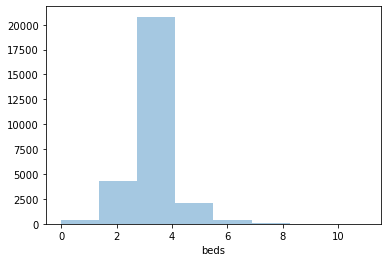

In [83]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=df2["beds"], bins=8, hist=True, kde=False, rug=False )

<AxesSubplot:xlabel='sqft'>

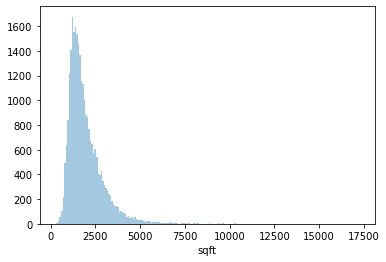

In [91]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=df2["sqft"], bins=200, hist=True, kde=False, rug=False )

(array([4634., 4114., 3804., 3311., 2955., 2352., 2040., 1565., 1285.,
         931.,  536.,  437.,   53.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([    0.        ,   333.33333333,   666.66666667,  1000.        ,
         1333.33333333,  1666.66666667,  2000.        ,  2333.33333333,
         2666.66666667,  3000.        ,  3333.33333333,  3666.66666667,
         4000.        ,  4333.33333333,  4666.66666667,  5000.        ,
         5333.33333333,  5666.66666667,  6000.        ,  6333.33333333,
         6666.66666667,  7000.        ,  7333.33333333,  7666.66666667,
         8000.        ,  8333.33333333,  8666.66666667,  9000.        ,
         9333.33333333,  9666.66666667, 10000.        ]),
 <BarContainer object of 30 artists>)

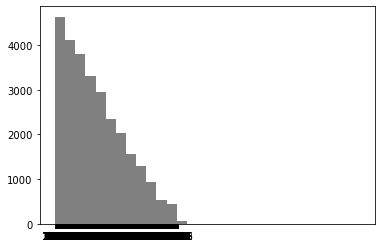

In [92]:
plt.hist(df.sqft, 30, range=[0, 10000], facecolor='gray', align='mid')

<AxesSubplot:xlabel='county'>

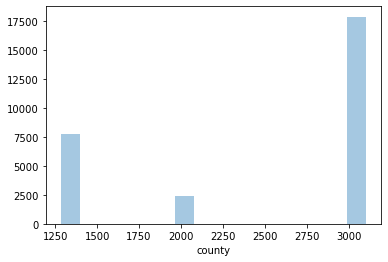

In [87]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=df["county"], hist=True, kde=False, rug=False )

<AxesSubplot:xlabel='zipcode'>

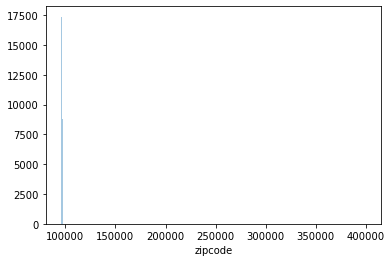

In [88]:
# Plot the histogram thanks to the distplot function
sns.distplot( a=df["zipcode"],bins=500,hist=True, kde=False, rug=False )

In [100]:
# time to scale
num_cols = ['beds','baths','sqft']
def use_min_max(X_train, X_validate, X_test, num_col):
    '''
    this function takes in X: train, validate, and test
    a list of numeric column names that were specified to use in the first go round of estimation,
    and fits a min-max scaler to the first dataframe only and then transforms all
    dataframes using this scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = MinMaxScaler(copy=True).fit(X_train[num_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[num_cols])
    X_validate_scaled_array = scaler.transform(X_validate[num_cols])
    X_test_scaled_array = scaler.transform(X_test[num_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=num_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=num_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=num_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [101]:
use_min_max(X_train, X_validate, X_test, num_cols)

(       beds     baths      sqft
 21625   0.3  0.181818  0.094877
 13705   0.4  0.227273  0.120251
 9147    0.3  0.090909  0.060953
 962     0.3  0.181818  0.094739
 26797   0.4  0.181818  0.074881
 ...     ...       ...       ...
 2565    0.3  0.181818  0.072123
 6673    0.3  0.090909  0.086051
 16329   0.4  0.181818  0.092533
 12981   0.3  0.181818  0.085569
 5948    0.3  0.272727  0.089361
 
 [15689 rows x 3 columns],
        beds     baths      sqft
 20338   0.4  0.272727  0.214232
 16152   0.3  0.090909  0.061987
 9769    0.4  0.272727  0.138454
 8852    0.2  0.090909  0.043853
 22535   0.2  0.136364  0.051989
 ...     ...       ...       ...
 24514   0.3  0.181818  0.063297
 25653   0.3  0.090909  0.047783
 9190    0.4  0.272727  0.148314
 17163   0.4  0.272727  0.121906
 4253    0.4  0.181818  0.113287
 
 [6724 rows x 3 columns],
        beds     baths      sqft
 12448   0.3  0.181818  0.083776
 711     0.3  0.363636  0.190581
 2278    0.3  0.181818  0.069365
 8922    0.3  0.181

##Takeaways from Prepare
df is prepped and ready to answer questions posed
X_train, etc. is prepped and ready for explore
there were no outliers in the dataset after cleaning and whittling it down

In [ ]:
def remove_outlier(df):
    '''
    This function will remove values that are 3 standard deviations above or below the mean for sqft, baths, beds, and tax_value.         (Our MVP values)
    '''
    new_df = df[(np.abs(stats.zscore(df['sqft'])) < 3)]
    new_df = df[(np.abs(stats.zscore(df['baths'])) < 3)]
    new_df = df[(np.abs(stats.zscore(df['beds'])) < 3)]
    new_df = df[(np.abs(stats.zscore(df['tax_value'])) < 3)]
    return df

In [ ]:
#remove_outlier(df)

In [ ]:
# cols = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','taxamount','assessmentyear']
# # impute cols using model
# imputer = SimpleImputer(strategy='most_frequent')

# imputer.fit(df[cols])

# df[cols] = imputer.transform(train[cols])
    

In [ ]:
# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

In [ ]:
# n removing outliers
# df = wrangle.remove_outliers(df, 1.5, ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount', 'assessmentyear', 'regionidcounty'])
# df.head()

In [ ]:
df.head()

In [ ]:
#narrow down the record to those in the "hot months" May-August 2017
# this df created so far is for answering the questions posed by team
# it will not be used to create models